# I. Spatial Relationships and Weights


## Пространственные взаимосвязи и соседство

В этой главе мы рассмотрим, как формализуются пространственные взаимосвязи между объектами.
Мы обсудим основные подходы к определению пространственного соседства:

- по смежности,
- по расстоянию,
- по _k_-ближайшим соседям.

Также познакомимся с понятием **матриц пространственных весов**, и разберём, как выбор схемы соседства может потенциально влиять на результаты пространственного анализа

> Понимание пространственного соседства является ключевым для пространственной статистики, поскольку большинство методов, изучаемых в рамках курса, требуют явного определения того, _какие объекты и каким образом связаны между собой_.


## 0. Подготовка данных


Импортируем библиотеки


In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

Загрузим данные, чтобы дальше не отвлекаться на их подготовку :)

Мы поработаем:

- со статистическими данными по муниципальным образованиям Краснодарского края и Республики Адыгея (источник — БДМО, Росстат);
- с данными о плотности населения в Краснодаре, агрегированными на регулярную квадратную сетку;
- с точечными данными о ДТП с участием пешеходов в Краснодаре (2017).

В этом разделе мы не будем анализировать значения показателей, а сосредоточимся на пространственной конфигурации данных. К самим показателям вернёмся позже.


**Загружаем данные о муниципалитетах для Краснодарского края и республики Адыгея**


In [2]:
muni = gpd.read_file('./data/krasnodar_adygea_muni.geojson')

muni.explore(tiles='cartodbpositron')

**Загружаем данные о плотности населения Краснодара, агрегированные по квадратной сетке регулярных ячеек**


In [3]:
sq_grid = gpd.read_file('./data/krs_pop_sqgrid.geojson')

sq_grid.explore(tiles='cartodbpositron')


**Загружаем точечные данные о ДТП в Краснодаре с участием пешеходов (в 2017 году)**


In [4]:
dtp_points = gpd.read_file('./data/krs_dtp_ped2017.geojson')

dtp_points = dtp_points.to_crs(dtp_points.estimate_utm_crs())

dtp_points.explore(tiles='cartodbpositron')

Skipping field Time: unsupported OGR type: 10


## 1. Пространственное соседство (Spatial Neighborhood)


**Подходы к определению пространственного соседства**

В пространственной статистике соседство можно определять на основе трёх базовых групп подходов:

- Соседство по смежности (contiguity-based) —  
  взаимодействия определяются наличием общей границы  
  _(административные районы, кварталы, ячейки сетки)_.

- Соседство по расстоянию (distance-based) —  
  предполагается физический радиус влияния  
  _(доступность)_.

- Соседство по _k_-ближайшим соседям (kNN) —  
  важно, чтобы у каждого объекта было одинаковое число соседей.

Эти подходы по-разному отвечают на вопрос:  
_*какие объекты считать «близкими» и как формально это зафиксировать*_

**Матрица пространственных весов**

Для формального описания соседства используется  
матрица пространственных весов.

На основе выбранного типа соседства строится матрица, в которой для каждой пары пространственных объектов определяются веса. В простом случае:

- значение `1` означает наличие соседства между объектами;
- значение `0` — его отсутствие.

В умолчанию рассматриваются соседи первого порядка —  
объекты, являющиеся непосредственными соседями  
(в соответствии с выбранным типом соседства).

При необходимости могут учитываться и соседи более высоких порядков:

- второго порядка — соседи соседей первого порядка;
- третьего порядка — соседи соседей второго порядка;
- и так далее.

**Веса связей**

Важно отметить, что матрица весов не всегда бинарная (0/1).  
Часто веса отражают силу пространственной связи, например:

- обратная зависимость от расстояния:  
  `w_ij = 1 / d_ij` _(чем ближе, тем сильнее связь)_;
- доля общей границы (для полигональных объектов);
- нормировка по строкам (_row-standardization_),  
  чтобы суммарное влияние соседей для разных объектов было сопоставимым

_*В рамках данного раздела основное внимание будет уделяться  
соседям первого порядка, однако также будут рассмотрены  
отдельные примеры для соседей более высоких порядков*_


### Соседство по смежности (contiguity-based)


**Идея:**  
Объекты считаются соседями, если между ними существует общая граница.  
Подход применяется преимущественно для площадных объектов – полигонов.

**Основные варианты**

- Rook (ладья) — соседство определяется наличием общей стороны.
- Queen (ферзь) — соседство определяется наличием общей стороны или вершины.


#### Rook


Два объекта считаются соседями по типу Rook, если они имеют общую сторону.


![Ладья](https://www.paulamoraga.com/book-spatial/book-spatial_files/figure-html/arealdata-neighborscontiguity-2.png)


##### Для регулярной сетки


Построим матрицу пространственных весов с помощью библиотеки `libpysal.weights`


In [5]:
from libpysal.weights import Rook

sq_grid = sq_grid.reset_index(drop=True) # сбросим индексы, чтобы потом использовать их как id

w_rook = Rook.from_dataframe(sq_grid, ids=sq_grid.index.tolist())# построим матрицу весов


Посмотрим на несколько первых элементов матрицы весов, чтобы понять её структуру


In [6]:
W = w_rook.full()[0]
n = 15 
dfW = pd.DataFrame(W[:n, :n])
dfW

0    1    2    3    4    5    6    7    8    9    10   11   12   13   14
0   0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1   1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2   0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3   0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
4   0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
5   0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
6   0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
7   0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
8   0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
9   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0
10  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0
11  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0
12  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0
13  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0
14  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0

По сути матрица пространственных весов W — это таблица связей между объектами.
В простейшем (бинарном) варианте: 1 — объект j является соседом i, 0 — не является


Для каждого объекта указан список id его соседей


In [7]:
list(w_rook.neighbors.items())[:5]

[(0, [1, 29]),
 (1, [0, 2, 30]),
 (2, [1, 3, 31]),
 (3, [32, 2, 4]),
 (4, [33, 3, 5])]

Выберем одну ячейку и посмотрим, какие объекты являются её соседями


In [8]:
sample_id = 443 # выбираем индекс элемента, находящегося в середине набора данных

neighbors = w_rook.neighbors[sample_id]  

print("ID ячейки:", sample_id)
print("Число rook-соседей 1-го порядка:", len(neighbors))
print("Соседи 1-го порядка:", neighbors)


ID ячейки: 443
Число rook-соседей 1-го порядка: 4
Соседи 1-го порядка: [472, 442, 444, 414]


Посмотрим расположение соседей на карте


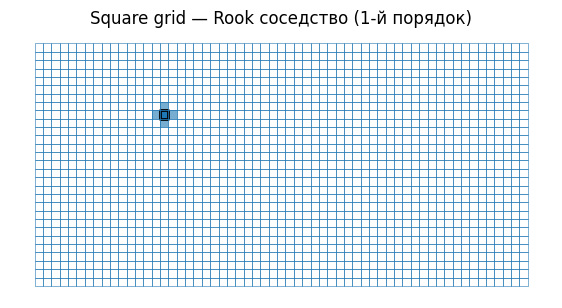

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

sq_grid.boundary.plot(ax=ax, linewidth=0.4) # все ячейки

sq_grid.loc[neighbors].plot(ax=ax, alpha=0.6) #соседи ячейки i

sq_grid.loc[[sample_id]].plot(ax=ax, edgecolor="black", linewidth=2) #ячейка i

ax.set_title("Square grid — Rook соседство (1-й порядок)")
ax.set_axis_off()
plt.show()


##### Для границ муниципалитетов


Повторим те же шаги для слоя с муниципалитетами Краснодарского края и Реуспублики Адыгея


Построим матрицу пространственных весов с помощью библиотеки `libpysal.weights`


In [10]:
muni = muni.reset_index(drop=True) # сбросим индексы, чтобы потом использовать их как id

w_rook_muni = Rook.from_dataframe(muni, ids=muni.index.tolist())# построим матрицу весов

Выберем один муниципалитет и посмотрим, какие объекты являются её соседями


In [11]:
muni_id = 48

neighbors_muni = w_rook_muni.neighbors[muni_id]  

print("ID ячейки:", muni_id)
print("Число rook-соседей 1-го порядка:", len(neighbors_muni))
print("Соседи 1-го порядка:", neighbors_muni)

ID ячейки: 48
Число rook-соседей 1-го порядка: 6
Соседи 1-го порядка: [51, 4, 37, 39, 7, 52]


Посмотрим расположение соседей на карте


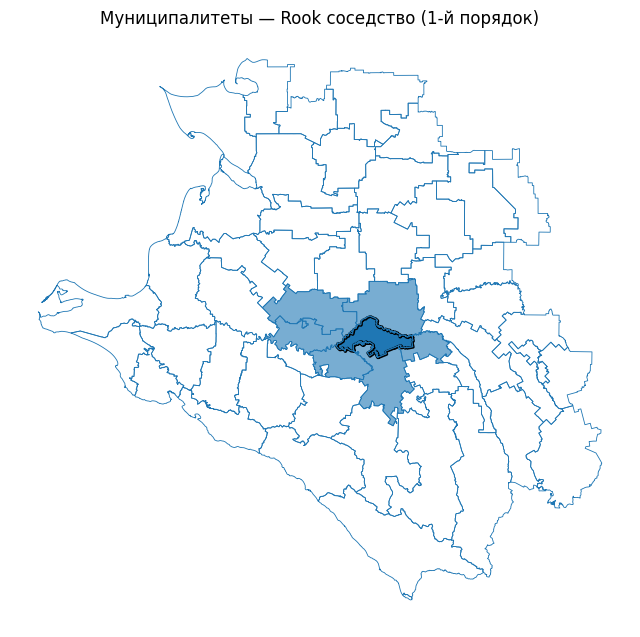

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

muni.boundary.plot(ax=ax, linewidth=0.6) # все границы
muni.loc[neighbors_muni].plot(ax=ax, alpha=0.6) # соседи муниципалитета i
muni.loc[[muni_id]].plot(ax=ax, edgecolor="black", linewidth=2)  # муниципалитет i

ax.set_title("Муниципалитеты — Rook соседство (1-й порядок)")
ax.set_axis_off()
plt.show()


#### Queen


Два объекта считаются соседями по типу Queen, если они имеют общую сторону или вершину


![Королева](https://www.paulamoraga.com/book-spatial/book-spatial_files/figure-html/arealdata-neighborscontiguity-1.png)


##### Для регулярной сетки


Построим матрицу пространственных весов с помощью библиотеки `libpysal.weights`


In [13]:
from libpysal.weights import Queen

w_queen_sq = Queen.from_dataframe(sq_grid, ids=sq_grid.index.tolist())


In [14]:
w_queen_sq.neighbors

{0: [1, 29, 30],
 1: [0, 2, 29, 30, 31],
 2: [32, 1, 3, 30, 31],
 3: [32, 33, 2, 4, 31],
 4: [32, 33, 34, 3, 5],
 5: [33, 34, 35, 4, 6],
 6: [34, 35, 36, 5, 7],
 7: [35, 36, 37, 6, 8],
 8: [36, 37, 38, 7, 9],
 9: [37, 38, 39, 8, 10],
 10: [38, 39, 40, 9, 11],
 11: [39, 40, 41, 10, 12],
 12: [40, 41, 42, 11, 13],
 13: [41, 42, 43, 12, 14],
 14: [42, 43, 44, 13, 15],
 15: [16, 43, 44, 45, 14],
 16: [17, 44, 45, 46, 15],
 17: [16, 18, 45, 46, 47],
 18: [48, 17, 19, 46, 47],
 19: [48, 49, 18, 20, 47],
 20: [48, 49, 50, 19, 21],
 21: [49, 50, 51, 20, 22],
 22: [50, 51, 52, 21, 23],
 23: [51, 52, 53, 22, 24],
 24: [52, 53, 54, 23, 25],
 25: [53, 54, 55, 24, 26],
 26: [54, 55, 56, 25, 27],
 27: [55, 56, 57, 26, 28],
 28: [56, 57, 27],
 29: [0, 1, 58, 59, 30],
 30: [0, 1, 2, 58, 59, 60, 29, 31],
 31: [32, 1, 2, 3, 59, 60, 61, 30],
 32: [33, 2, 3, 4, 60, 61, 62, 31],
 33: [32, 34, 3, 4, 5, 61, 62, 63],
 34: [64, 33, 35, 4, 5, 6, 62, 63],
 35: [64, 65, 34, 36, 5, 6, 7, 63],
 36: [64, 65, 66, 35,

Выберем одну ячейку и посмотрим, какие объекты являются её соседями


In [15]:
sample_id = 443

neighbors_queen = w_queen_sq.neighbors[sample_id]

print("ID ячейки:", sample_id)
print("Число queen-соседей 1-го порядка:", len(neighbors_queen))
print("Соседи 1-го порядка:", neighbors_queen)

ID ячейки: 443
Число queen-соседей 1-го порядка: 8
Соседи 1-го порядка: [471, 472, 473, 442, 444, 413, 414, 415]


Посмотрим расположение соседей на карте


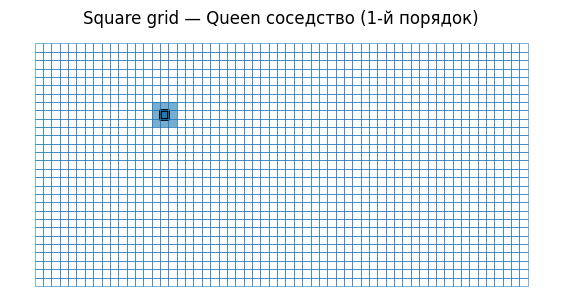

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

sq_grid.boundary.plot(ax=ax, linewidth=0.4) # все границы
sq_grid.loc[neighbors_queen].plot(ax=ax, alpha=0.6) # соседи ячейки i
sq_grid.loc[[sample_id]].plot(ax=ax, edgecolor="black", linewidth=2) # ячейка i

ax.set_title("Square grid — Queen соседство (1-й порядок)")
ax.set_axis_off()
plt.show()

##### Для границ муниципалитетов


Этот шаг предлагается выполнить самостоятельно.

Будет ли матрица пространственных весов, построенная по типу Queen, отличаться от матрицы типа Rook для рассматриваемых муниципалитетов?  
Если да, в чём именно будут заключаться эти различия?


> Соседство по смежности основано на геометрическом контакте объектов и чаще всего применяется для полигональных данных (административные единицы, зоны, ячейки сетки).
> Тип Rook учитывает только общую границу и формирует более “строгое” локальное соседство.
> Тип Queen дополнительно учитывает касание по вершинам и, как правило, приводит к большему числу соседей и более плотной структуре связей.
> Выбор между Rook и Queen влияет на число соседей у объектов и связность всей системы, а значит — на результаты последующего анализа пространственной автокорреляции и моделирования, о которых будем говорить в следующих разделах.


#### Соседи второго порядка


**Соседи второго порядка** — это объекты, которые не являются непосредственными соседями,
но граничат с соседями первого порядка (то есть _«соседи соседей»_).

Иногда пространственный эффект выходит за пределы ближайших границ: влияние может передаваться через цепочки соседних территорий (например, при миграциях, учёте транспортных связей и пр.).
В таких случаях используют **соседство более высоких порядков**, позволяющее учитывать более «длинные» пространственные связи.

На примере соседей второго порядка, определённых по типу **Rook** для муниципалитетов,
мы разберём общий подход к работе с соседями более высоких порядков, который можно аналогично применять к другим типам соседства по смежности.


Определим соседей первого порядка, как мы это делали выше


In [17]:
w = Rook.from_dataframe(muni, ids=muni.index.tolist())

С помощью метода `higher_order` из модуля `libpysal.weights` определим соседей второго порядка — соседей соседей для каждого муниципалитета


In [18]:
from libpysal.weights import higher_order

w2 = higher_order(w, k=2)

list(w2.neighbors.items())[:5]


[(0, [41, 50, 40, 7, 30, 39, 25, 33, 42, 10]),
 (1, [53, 48, 52, 24, 51, 46, 50, 45, 35, 44, 21]),
 (2, [32, 22, 16, 9]),
 (3, [15, 10, 28, 37, 32, 8, 7, 16, 25, 20, 29, 38]),
 (4, [39, 43, 47, 24, 33, 37, 50, 18, 45, 21, 7])]

Посмотрим на карте соседей первого и второго порядков для одного из муниципалитетов


In [19]:
muni_id = 48

#Выбираем соседей первого порядка
neighbors_1 = w.neighbors[muni_id]

#Выбираем соседей второго порядка
neighbors_2 = w2.neighbors[muni_id]

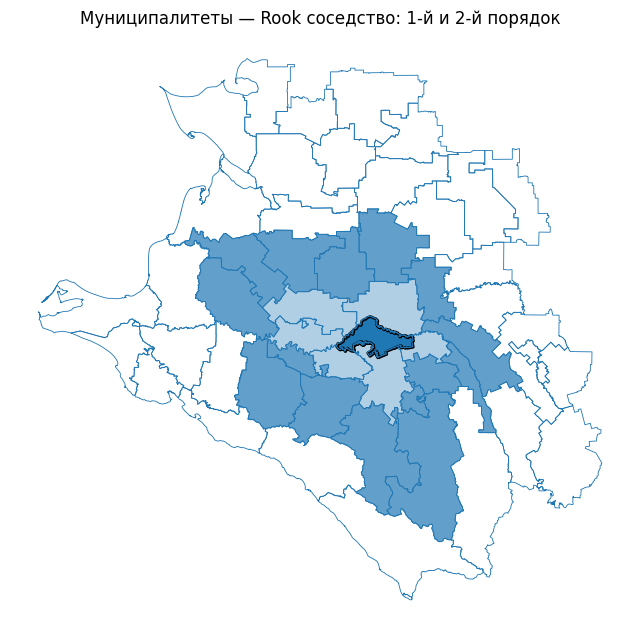

In [20]:
# Показываем их на карте
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

muni.boundary.plot(ax=ax, linewidth=0.6)# все границы

muni.loc[neighbors_1].plot(ax=ax, alpha=0.35) # границы второго порядка муниципалитета i

muni.loc[neighbors_2 ].plot(ax=ax, alpha=0.70) # границы первого порядка муниципалитета i

muni.loc[[muni_id]].plot(ax=ax, edgecolor="black", linewidth=2) # ячейка i

ax.set_title("Муниципалитеты — Rook соседство: 1-й и 2-й порядок")
ax.set_axis_off()
plt.show()



> Соседи более высоких порядков позволяют учитывать косвенные пространственные связи, выходящие за рамки непосредственного соседства.
> Соседи второго порядка отражают влияние, передающееся через соседей первого порядка, и могут быть полезны, когда:
> пространственные процессы распространяются по цепочке территорий;
> влияние не ограничивается общей границей.


### Соседство по расстоянию (distance-band)


**Идея**: объекты — соседи, если расстояние между ними меньше заданного порога d. Подходит и для точечных данных, но в целом универсален для любых типов геометрий

> **Важно:** для построения соседства по расстоянию нужны метры (данные должны быть в метрических СК).


С помощью инструментов библиотеки `libpysal.weights` можно строить матрицы весов на основе заданного расстояния. Рассмотрим такой тип соседства на примере точечных данных о ДТП с участием пешеходов в Краснодаре


In [21]:
from libpysal.weights import DistanceBand

dtp_points = dtp_points.reset_index(drop=True) ## сбросим индексы, чтобы потом использовать их как id

# Задаём порог расстояния (в метрах) и строим веса distance band
d = 1000 

w_dist = DistanceBand.from_dataframe(
    dtp_points,
    threshold=d,
    silence_warnings=True   # чтобы не ругался на "острова" при малом d
)



Посмотрим на результат: Для каждой из точек представлен список её "соседей" - тех точек, которые расположены в пределах заданного радиуса


In [22]:
list(w_dist.neighbors.items())[:6]

[(0, [2, 8, 70, 128, 179, 306, 329, 347]),
 (1, [97, 135, 152, 185, 194, 218, 231, 294, 311, 316, 344]),
 (2, [0, 6, 8, 13, 40, 101, 133, 179, 183, 192, 286, 306, 329, 347, 384]),
 (3, [91, 150, 215, 270]),
 (4, [36, 128, 212, 372, 383]),
 (5, [299, 300, 321, 335, 386, 387])]

Визуализируем выбранную точку и её соседей на карте


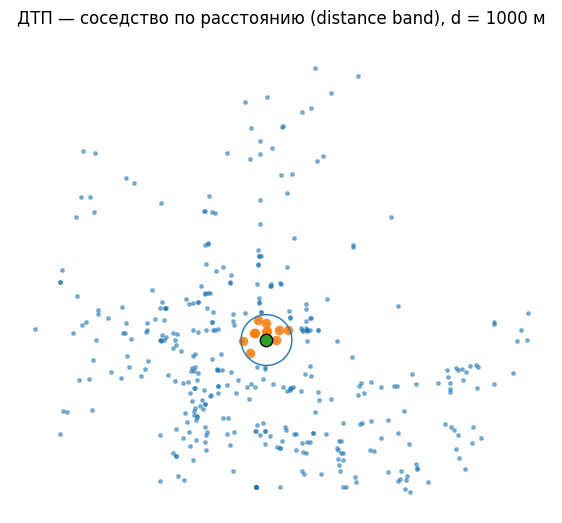

In [23]:
point_id = dtp_points.index[len(dtp_points)//2]

# выбираем её соседей
neighbors_1 = w_dist.neighbors[point_id]


#визуализируем результат
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

dtp_points.plot(ax=ax, markersize=6, alpha=0.5) # все точки

dtp_points.loc[neighbors_1].plot(ax=ax, markersize=35, alpha=0.8) # соседи точки i

dtp_points.loc[[point_id]].plot(ax=ax, markersize=80, edgecolor="black") # точка i

dtp_points.loc[[point_id]].buffer(d).boundary.plot(ax=ax, linewidth=1) # круг радиуса d вокруг точки i

ax.set_title(f"ДТП — соседство по расстоянию (distance band), d = {d} м")
ax.set_axis_off()
plt.show()

Посчитаем количество соседей для каждой точки


In [24]:
n_neighbors = pd.Series(w_dist.neighbors).apply(len)

In [25]:
n_neighbors

0       8
1      11
2      15
3       4
4       5
       ..
383     5
384    16
385     5
386     1
387     1
Length: 388, dtype: int64

Определим топ-10 точек с максимальным количеством соседей


In [26]:
top10 = n_neighbors.sort_values(ascending=False).head(10)
dtp_top10 = dtp_points.loc[top10.index].copy()
dtp_top10["n_neighbors"] = top10.values
dtp_top10


KartId  rowNum                date     District              DTP_V  \
42   207711910     131 2017-01-22 00:11:00  Г.КРАСНОДАР  Наезд на пешехода   
376  208576307     197 2018-01-15 00:01:00  Г.КРАСНОДАР  Наезд на пешехода   
126  206797568     369 2017-01-18 00:09:00  Г.КРАСНОДАР  Наезд на пешехода   
199  205383008     618 2017-01-08 00:06:00  Г.КРАСНОДАР  Наезд на пешехода   
160  206197907     462 2017-01-14 00:08:00  Г.КРАСНОДАР  Наезд на пешехода   
43   207699038     132 2017-01-21 00:11:00  Г.КРАСНОДАР  Наезд на пешехода   
167  206132911     477 2017-01-08 00:08:00  Г.КРАСНОДАР  Наезд на пешехода   
182  205707737     542 2017-01-07 00:07:00  Г.КРАСНОДАР  Наезд на пешехода   
200  205359085     623 2017-01-06 00:06:00  Г.КРАСНОДАР  Наезд на пешехода   
334  209053891      97 2018-01-28 00:02:00  Г.КРАСНОДАР  Наезд на пешехода   

     POG  RAN  K_TS  K_UCH  coord_w  coord_l  \
42     0    1     1      2  45.0344  38.9739   
376    0    1     1      2  45.0333  38.9667   
126    0    1     1      2   45.035  38.9689   
199    0    1     1      2   45.035  38.9692   
160    0    1     1      2  45.0378  38.9703   
43     0    1     1      2  45.0308  38.9728   
167    0    1     1      2  45.0294  38.9742   
182    0    1     1      2  45.0294  38.9742   
200    0    1     1      2  45.0214  38.9742   
334    0    1     1      2  45.0278  38.9736   

                                         address  \
42               г Краснодар, ул Красная ДЛИННАЯ   
376               г Краснодар, ул Коммунаров 268   
126           г Краснодар, ул Коммунаров Путевая   
199          г Краснодар, ул Октябрьская Длинная   
160         г Краснодар, ул Октябрьская Калинина   
43                    г Краснодар, ул Красная 79   
167     г Краснодар, ул Красных Партизан Баумана   
182      г Краснодар, ул Красноармейская Чапаева   
200           г Краснодар, ул им Орджоникидзе 54   
334  г Краснодар, ул Красноармейская Карасунская   

                           geometry  n_neighbors  
42   POINT (497944.152 4986772.147)           28  
376  POINT (497376.971 4986650.158)           25  
126  POINT (497550.337 4986838.939)           25  
199   POINT (497573.967 4986838.93)           25  
160  POINT (497660.725 4987149.944)           25  
43   POINT (497857.373 4986372.259)           24  
167    POINT (497967.606 4986216.7)           24  
182    POINT (497967.606 4986216.7)           24  
200  POINT (497967.322 4985327.997)           23  
334  POINT (497920.283 4986038.974)           23

Посмотрим на точки на карте


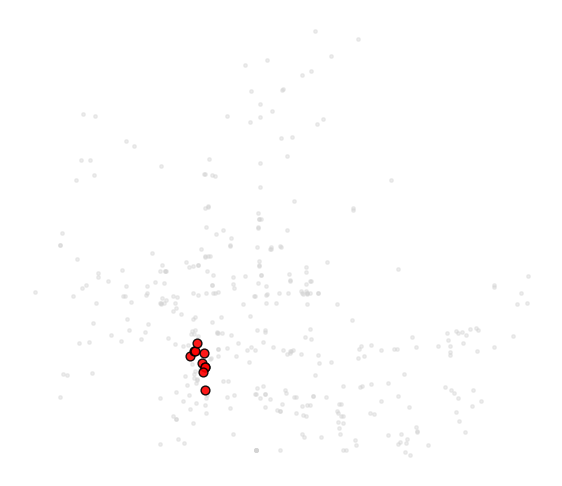

In [27]:
# визуализируем результат
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

dtp_points.plot(
    ax=ax,
    markersize=6,
    alpha=0.4,
    color="lightgrey"
)  # все точки ДТП

dtp_top10.plot(
    ax=ax,
    markersize=40,
    alpha=0.9,
    color="red",
    edgecolor="black"
)  # точки с максимальным числом соседей

ax.set_axis_off()

> Соседство по расстоянию связывает объекты, находящиеся друг от друга не дальше заданного порога. Такой подход можно применять как к точечным, так и к полигональным данным.
> Он хорошо подходит для процессов, у которых есть физический радиус влияния, но при этом чувствителен к выбору порога расстояния. Слишком маленький радиус приводит к появлению «островов» — объектов без соседей, а слишком большой делает связи слишком общими, где могут потеряться локальные закономерности


### Соседство по k-ближайшим соседям (k-nearest neighbors, kNN)


**Идея**: у каждого объекта есть k-соседей – самых близких по расстоянию.

Рассмотрим этот тип соседства на примере данных о ДТП с участием пешеходов в Краснодаре.


С помощью инструментов библиотеки `libpysal.weights` можно также строить матрицы весов на основе k-ближайших соседей


In [28]:
from libpysal.weights import KNN

k = 8
w_knn = KNN.from_dataframe(dtp_points, k=k)

Посмотрим, какие объекты являются соседями для каждой точки


In [29]:
list(w_knn.neighbors.items())[:5]

[(0, [329, 306, 8, 179, 128, 2, 70, 347]),
 (1, [135, 311, 194, 316, 231, 344, 185, 218]),
 (2, [179, 347, 101, 40, 183, 13, 133, 306]),
 (3, [150, 270, 91, 215, 281, 203, 219, 158]),
 (4, [372, 128, 212, 383, 36, 283, 226, 8])]

Посмотрим на карте соседей для одной из точек.


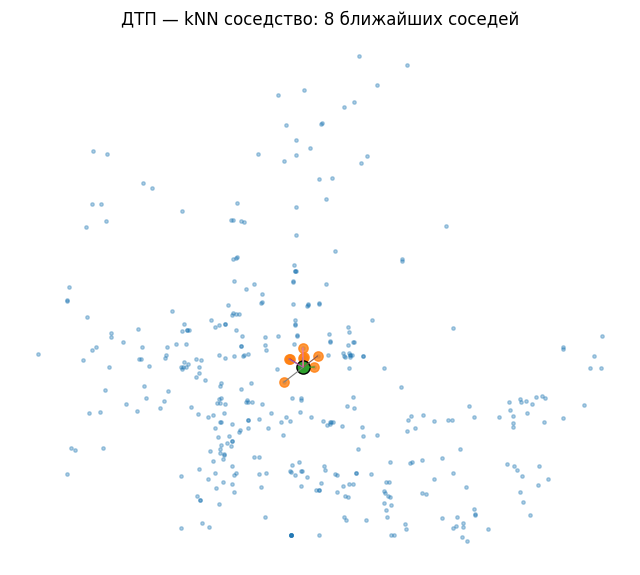

In [30]:
point_id = dtp_points.index[len(dtp_points)//2]

neighbors_1 = w_knn.neighbors[point_id]

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

dtp_points.plot(ax=ax, markersize=6, alpha=0.35) # все точки

dtp_points.loc[neighbors_1].plot(ax=ax, markersize=45, alpha=0.8) # k-ближайших соседей точки i

dtp_points.loc[[point_id]].plot(ax=ax, markersize=90, edgecolor="black") # точка i

#Линии: точка i -> сосед
fx, fy = dtp_points.loc[point_id].geometry.x, dtp_points.loc[point_id].geometry.y
for j in neighbors_1:
    x, y = dtp_points.loc[j].geometry.x, dtp_points.loc[j].geometry.y
    ax.plot([fx, x], [fy, y], linewidth=0.8)

ax.set_title(f"ДТП — kNN соседство: {k} ближайших соседей")
ax.set_axis_off()
plt.show()

> Соседство по k-ближайшим соседям обеспечивает фиксированное число соседей для каждого объекта, независимо от пространственной плотности данных.
> Этот подход особенно полезен:
> при неравномерном распределении точек;
> при наличии “островов” в distance-band соседстве;
> когда важно, чтобы все объекты были включены в анализ.
> Однако kNN может соединять достаточно удалённые объекты в разреженных областях, поэтому выбор параметра
> k должен быть обоснован.


% An admonition containing a note
:::{note}
Хотя мы показали distance-band и kNN на точках, эти подходы применимы и к полигонам (например, по центроидам).
Это полезно, когда смежность по границам плохо отражает взаимодействия: есть изолированные территории, полигоны сильно разного размера или нужно, чтобы у каждого объекта было одинаковое число соседей.
:::


## 2. Пространственные веса (Spatial Weights)


В первом разделе мы разобрали, как определить пространственное соседство. Теперь кратко рассмотрим особенности **пространственных весов**, которые важно учитывать при дальнейшем анализе.

Нас будут интересовать три ключевых аспекта:

1. у разных объектов может быть разное число соседей;
2. необходимость нормировки весов при сравнении объектов с разным числом соседей;
3. наличие «островов» — объектов без соседей.


### 2.1 Разное число соседей

Даже при одном и том же правиле (например, Rook) у объектов может быть разное число соседей, которое зависит от их положения в пространстве и геометрии объектов.

Посмотрим на количество соседей для каждого из муниципалитетов Краснодарского края и Республики Адыгея


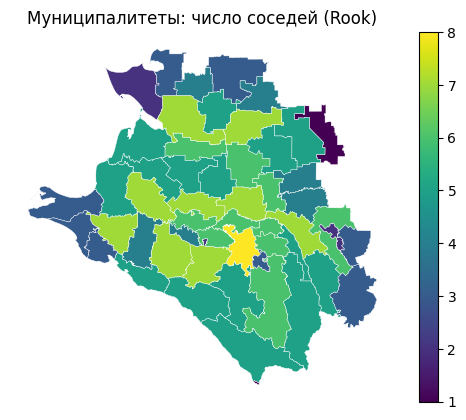

count    54.000000
mean      4.851852
std       1.686880
min       1.000000
25%       4.000000
50%       5.000000
75%       6.000000
max       8.000000
Name: n_neighbors_rook, dtype: float64

In [31]:
# Определяем матрицу соседства
w_rook_muni = Rook.from_dataframe(muni, ids=muni.index.tolist())

# Извлекаем количество соседей для каждого муниципалитета
deg_m = pd.Series(w_rook_muni.cardinalities, name="n_neighbors")
# Добавляем число соседей в таблицу муниципалитетов
muni["n_neighbors_rook"] = muni.index.map(deg_m).fillna(0).astype(int)

# Визуализируем число соседей на карте
ax = muni.plot(column="n_neighbors_rook", legend=True, linewidth=0.3, edgecolor="white")
ax.set_title("Муниципалитеты: число соседей (Rook)")
ax.set_axis_off()
plt.show()

muni["n_neighbors_rook"].describe()

> У разных объектов может быть различное число соседей даже при одном и том же типе соседства.
> Если веса не стандартизированы, объекты с большим числом соседей оказывают более сильное суммарное влияние, что может искажать интерпретацию пространственных эффектов.


### 2.2 Стандартизация весов (row-standardization)

Часто веса **нормируют по строкам**, чтобы сумма весов для каждого объекта была равна 1.
Это полезно, когда у объектов сильно различается число соседей.


Посмотрим на веса соседей для одного муниципалитета до стандартизации


In [32]:
print(w_rook_muni.weights[3])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [33]:
# Стандартизация по строкам
w_rook_muni.transform = "R"


Посмотрим на веса соседей для одного муниципалитета после стандартизации


In [34]:
print(w_rook_muni.weights[3])


[0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666]


При нормировке объект с большим числом соседей получает **меньший вес на каждого соседа**.


> Стандартизация весов позволяет сделать вклад соседей сопоставимым для всех объектов независимо от их количества.
> После row-standardization сумма весов в каждой строке матрицы равна единице, поэтому влияние каждого объекта определяется не числом соседей, а их относительным вкладом.
> По этой причине стандартизированные веса чаще всего используются при расчёте показателей пространственной автокорреляции и в пространственных регрессионных моделях (о которых мы поговорим в следюущих разделах).


### 2.3 «Острова»: объекты без соседей

Иногда при выбранном типе и параметрах соседства часть объектов может не иметь ни одного соседа. Такие объекты принято называть «островами». Их наличие важно учитывать, так как они требуют особого внимания при дальнейшем анализе.

Ниже посчитаем число соседей для точек ДТП в радиусе **200 м** и покажем точки с 0 соседей.


Число 'островов' (0 соседей): 209 из 388


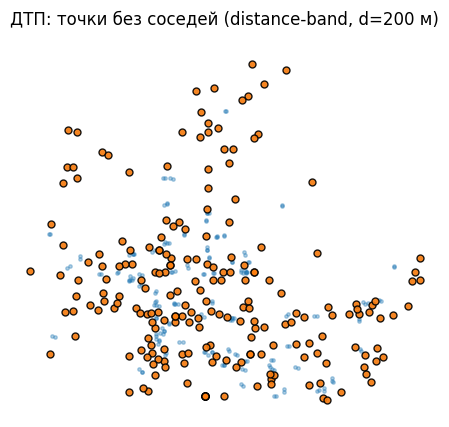

In [35]:
d = 200  # метров
w_dist = DistanceBand.from_dataframe(dtp_points, threshold=d, binary=True, silence_warnings=True)

deg = pd.Series(w_dist.cardinalities, name="n_neighbors")
dtp_points["n_neighbors_d200"] = dtp_points.index.map(deg).fillna(0).astype(int)

n_islands = (dtp_points["n_neighbors_d200"] == 0).sum()
print("Число 'островов' (0 соседей):", n_islands, "из", len(dtp_points))

ax = dtp_points.plot(markersize=6, alpha=0.35)
dtp_points[dtp_points["n_neighbors_d200"] == 0].plot(ax=ax, markersize=25, alpha=0.9, edgecolor="black")
ax.set_title("ДТП: точки без соседей (distance-band, d=200 м)")
ax.set_axis_off()
plt.show()


> «Островами» называют объекты, у которых отсутствуют соседи при выбранном типе и параметрах соседства.
> Чаще всего они возникают при использовании distance-band соседства со слишком малым порогом расстояния.
> Наличие «островов» требует отдельного внимания, так как такие объекты могут быть исключены из анализа или приводить к некорректной интерпретации результатов. На практике проблему решают изменением параметров соседства или выбором альтернативного подхода, например kNN.


## 3. Итог


В этом разделе мы рассмотрели основные способы задания пространственного соседства и построения матриц пространственных весов.

Пространственное соседство представляет собой формализацию того, **какие объекты считаются связанными между собой**. Различные типы соседства отражают разные предположения о механизмах пространственного взаимодействия и по-разному описывают структуру связей в данных. Поэтому выбор матрицы пространственных весов - один из важных шагов последющего анализа.

Один и тот же набор пространственных данных может приводить к различным результата в зависимости от выбранного типа соседства. Поэтому важно понимать разные подходы к определению пространственного соседства и их особенности
